# Track Selections

**Motivation:** From my CTIDE pres, PF asked me if the RNN was more performant for high efficiency or high purity track selections. My preliminary selections seemed to suggest that it was more performant for higher efficiencies, so I wanted to try loosening some of these cuts to see how the alg performed.

Since in the meantime, I had started exploring the deep sets architecture, which is more physically motivated and takes shorter to train, I decided to do these studies with this architecture instead!

In [2]:
import numpy as np
import h5py
import sys
import pandas as pd
import xarray as xr

sys.path.append("../..")
from usefulFcts import *
from trainNet import *
from plottingFcts import *

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


## Step 1: Plot the inputs

This is really just a sanity check to make sure that the input distributions make sense, and I'm capping at the right number of tracks.

In [46]:
subDir = 'mc16d_PFlow_ttbar'
dataDir = '../../data/' + subDir
vStr = "sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits"
myTrkSelection = "_pt_700_d0_2_z0sinTheta_6"
nTrks = 25
dataTagTrain = "3mtrain_{}trks{}_{}".format(nTrks,myTrkSelection,vStr)
dataTagTest  = "2mtest_{}trks{}_{}_sd0_rev".format(nTrks,myTrkSelection,vStr)

f_name = "{}/data_{}.hdf5".format(dataDir,dataTagTest)
f = h5py.File(f_name,"r")

X = f['X_test'][:]
y = f['y_test'][:]
ix = f['ix_test'][:]

f.close()

nTest, nTrks, nFeatures = X.shape

# Also, open the scaling file
s_name = "{}/scale_{}.json".format(dataDir,dataTagTrain)
with open(s_name, 'r') as sfile:
    s = json.load(sfile)

In [19]:
f_name

'../../data/mc16d_PFlow_ttbar/data_2mtest_25trks_pt_700_d0_2_z0sinTheta_6_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_sd0_rev.hdf5'

In [20]:
trk_vars = strToList(vStr,'_')
trk_vars.remove('logNorm')
trk_vars.remove('norm')
trk_vars

['sd0',
 'sz0',
 'nNextToInnHits',
 'nInnHits',
 'nsharedBLHits',
 'nsplitBLHits',
 'nsharedPixHits',
 'nsplitPixHits',
 'nsharedSCTHits',
 'ptfrac',
 'dr',
 'nPixHits',
 'nSCTHits']

In [21]:
logNormVars = trk_vars[-4:-2]
normVars = trk_vars[-4:]

In [22]:
xlabels = ['$s_{d0}$', '$s_{z0}$', 
           'PIX1 hits', 'IBL hits',
           'IBL shared hits', 'IBL split hits', 
           'shared pixel hits', 'split pixel hits',
           'shared SCT hits','$p_T^{frac}$','$\Delta R$',
           'pixel hits','SCT hits'
          ]

var_bins = [50,50,
            5,5,5,5,
            10,10,10,
            50,50,
            10,21]

var_ranges = [(-10,10),(-10,10),
              (-0.5,4.5),(-0.5,4.5),(-0.5,4.5),(-0.5,4.5),
              (-0.5,9.5),(-0.5,9.5),(-0.5,9.5),
              (0,0.4), (0, .4),
              (-0.5,9.5),(-0.5,20.5)]

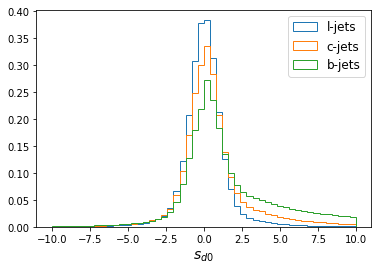

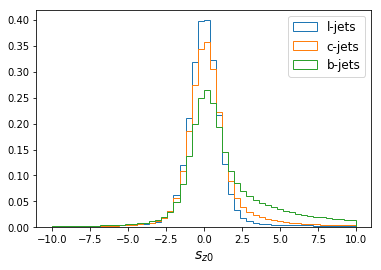

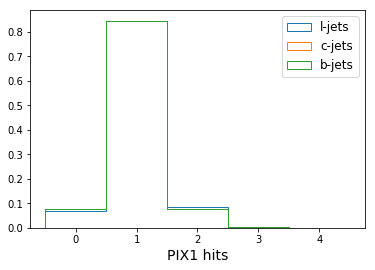

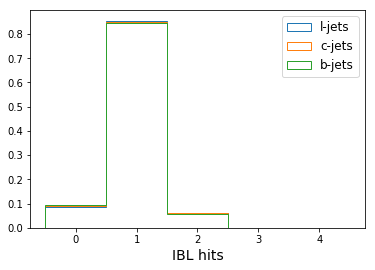

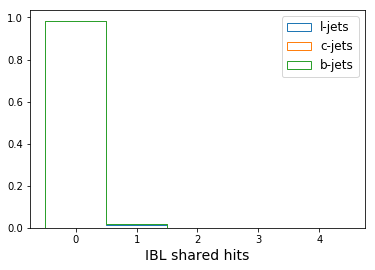

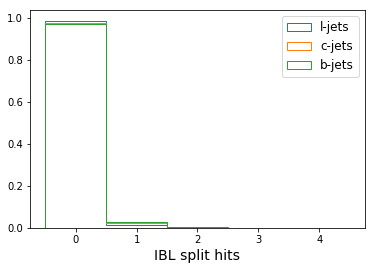

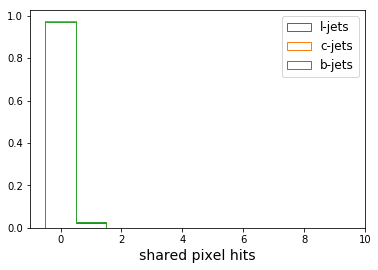

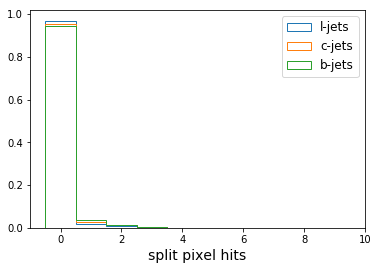

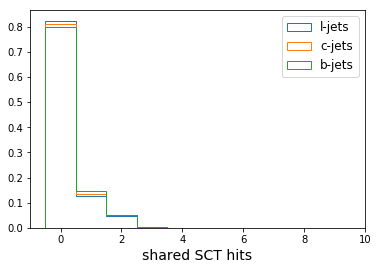

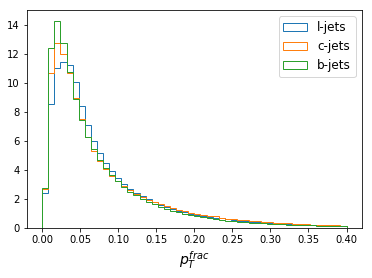

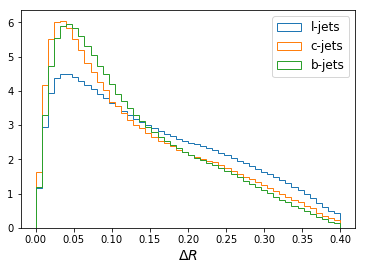

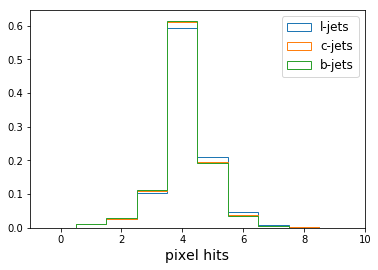

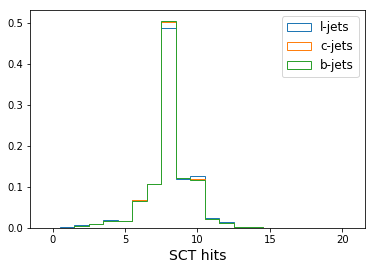

In [23]:
# Get the mask since all of the truth labels are track level variables
y_trks = np.ones_like(X[:,:,0])
y_trks = y_trks * y.reshape(-1,1)

# This mask selects the non-masked tracks in the jet
mask = getTrkMask(X)
y_trks = y_trks[mask]

for j, (trk_var, xlabel, nBins, myRange) in enumerate(zip(trk_vars, xlabels,var_bins, var_ranges)):

    # Access the non-masked trks in the jet for this trk feature
    var = X[:,:,j][mask].copy()

    if trk_var in normVars:
        mu, sigma = s[trk_var]['mean'], s[trk_var]['sd']
        var = mu + sigma * var

    if trk_var in logNormVars:
        var = np.exp(var)

    plt.figure(j)

    for yi, flav in zip(range(3), ['l','c','b']):

        plt.hist(var[y_trks == yi],
                 range=myRange,bins=nBins,
                 histtype='step', density=True, 
                 color='C{}'.format(yi), 
                 label='{}-jets'.format(flav))

    plt.legend(fontsize=12)  
    plt.xlabel(xlabel,fontsize=14)            
    #plt.savefig('../../figures/mc16d_PFlow_ttbar/Topo_cf/{}.pdf'.format(trk_var))

plt.show()

Ok, but the question that I really wanted to answer was: is 25 an adequate cap for the # of tracks?

In [24]:
mask

array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])

In [25]:
mask.shape

(1500000, 25)

In [26]:
nTrksCap = mask.sum(axis=-1)

l-jets: 6.132577269141146 tracks
c-jets: 6.426401645618063 tracks
b-jets: 7.4292157761642095 tracks


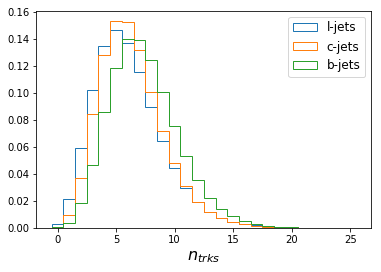

In [30]:
for yi, flav in zip(range(3), ['l','c','b']):

        plt.hist(nTrksCap[y == yi],
                 range=(-0.5,25.5),bins=26,
                 histtype='step', density=True, 
                 color='C{}'.format(yi), 
                 label='{}-jets'.format(flav))
        print('{}-jets: {} tracks'.format(flav, np.mean(nTrksCap[y == yi])))
plt.legend(fontsize=12)  
plt.xlabel('$n_{trks}$',fontsize=16)            
#plt.savefig('../../figures/mc16d_PFlow_ttbar/Topo_cf/{}.pdf'.format(trk_var))
plt.show()
        

In [34]:
trk_xr = xr.open_dataarray('{}/trk_2mtest_{}trks{}_sd0_rev.nc'.format(dataDir,nTrks,myTrkSelection))

In [35]:
pt = trk_xr.loc[:,:,'pt'].values
d0 = trk_xr.loc[:,:,'ip3d_d0'].values
z0sinTheta = trk_xr.loc[:,:,'ip3d_z0'].values

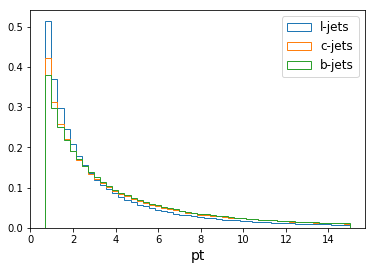

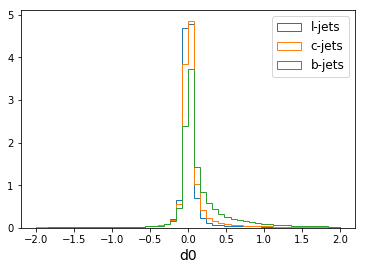

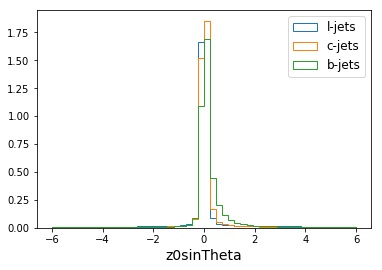

In [36]:
for var, xlabel, nBins, myRange in zip([pt,d0,z0sinTheta],
                                       ['pt','d0','z0sinTheta'],
                                       [50,50,50],
                                       [(.7,15),(-2,2),(-6,6)]):

    plt.figure()
    for yi, flav in zip(range(3), ['l','c','b']):

        plt.hist(var[mask][y_trks == yi],
                 range=myRange,bins=nBins,
                 histtype='step', density=True, 
                 color='C{}'.format(yi), 
                 label='{}-jets'.format(flav))

    plt.legend(fontsize=12)  
    plt.xlabel(xlabel,fontsize=14)            
    #plt.savefig('../../figures/mc16d_PFlow_ttbar/Topo_cf/{}.pdf'.format(trk_var))

plt.show()

In [37]:
np.min(pt[pt!=0])

0.70000017

Good news: It looks like I understand how to apply these cuts successfully!

## Step 2: Evaluate a trained model

Ok, so the result of my `Hyperparameter-Scan` notebook was that I didn't need as complex model as I was using to get appropriate performance.

So I'm just going to use the default parameters from the paper, since I expect I might need a more complex model when I make the optimization problem more difficult.

For comparison, I'm going to also be loading in
1. The LSTM model trained with the IP3D selections
2. The Deep-Sets model trained with the IP3D selections

In [44]:
dataDir

'../../data/mc16d_PFlow_ttbar'

In [49]:
# Data: 3d selections
test_ip3d  = "2mtest_15trks_{}_sd0_rev".format(vStr)

f_name = "{}/data_{}.hdf5".format(dataDir,test_ip3d)
f = h5py.File(f_name,"r")

X_ip3d = f['X_test'][:]
y_ip3d = f['y_test'][:]
ix_ip3d = f['ix_test'][:]

f.close()

Initialize method from myModel()
Loading previously trained LSTM
min: -6.61, max: 11.12


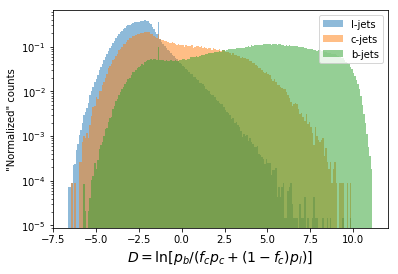

Initialize method from myModel()
Loading previously trained PFN
Load in the previously saved efficiency file


In [50]:
leffs, ceffs, beffs = [],[],[]

modelDir = '../../models/'+subDir
figDir = '../../figures/'

# LSTM - ip3d selections
tag_lstm_ip3d = "3mtrain_15trks_{}_sd0_rev".format(vStr)
m = myLSTM(modelDir=modelDir, nFeatures=nFeatures, dataTag=tag_lstm_ip3d, loadModel=True)
leff, ceff, beff = getEffs(m, X_ip3d, y_ip3d, ix_ip3d,
                             figDir=figDir,subDir=subDir,modelDir=modelDir)

leffs.append(leff)
ceffs.append(ceff)
beffs.append(beff)

# PFN - ip3d selections
dense_sizes = [100] * 3
ppm_sizes = [100,100,128]
tag_pfn_ip3d = "2mtrain_15trks_{}".format(vStr)
m = myPFN(ppm_sizes, dense_sizes, latent_dropout=0,
          timeSteps=nTrks, nFeatures=nFeatures,
          modelDir=modelDir, dataTag=tag_pfn_ip3d, loadModel=True)
leff, ceff, beff = getEffs(m, X_ip3d, y_ip3d, ix_ip3d, figDir=figDir, 
                            subDir=subDir,modelDir=modelDir)


leffs.append(leff)
ceffs.append(ceff)
beffs.append(beff)

Initialize method from myModel()
Loading previously trained PFN
acc
loss
val_acc
val_loss


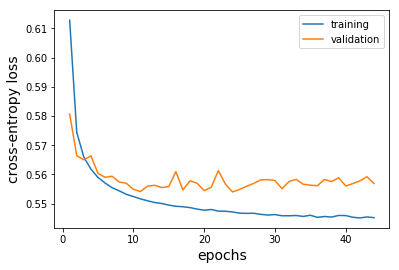

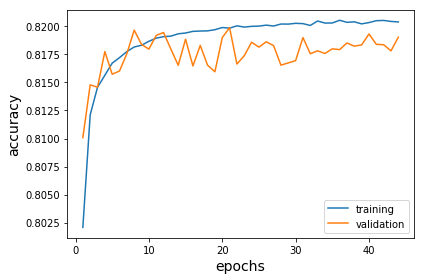

Load in the previously saved efficiency file


In [51]:
# PFN
dense_sizes = [100] * 3
ppm_sizes = [100,100,128]
m = myPFN(ppm_sizes, dense_sizes, latent_dropout=0,
          timeSteps=nTrks, nFeatures=nFeatures,
          modelDir=modelDir, dataTag=dataTagTrain, loadModel=True)

trainingMetrics(m.modelName,m.modelDir)

leff, ceff, beff = getEffs(m, X, y, ix, figDir=figDir, 
                           subDir=subDir,modelDir=modelDir)

leffs.append(leff)
ceffs.append(ceff)
beffs.append(beff)

/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:147: RuntimeWarning: divide by zero encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:165: RuntimeWarning: invalid value encountered in true_divide
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:117: RuntimeWarning: invalid value encountered in multiply
  d = ((2*h0 + h1)*m0 - h0*m1) / (h0 + h1)
../../plottingFcts.py:573: RuntimeWarning: invalid value encountered in sqrt
  eff_err = lambda x, N: np.sqrt( x*(1-x) / N)
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:147: RuntimeWarning: invalid value encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk


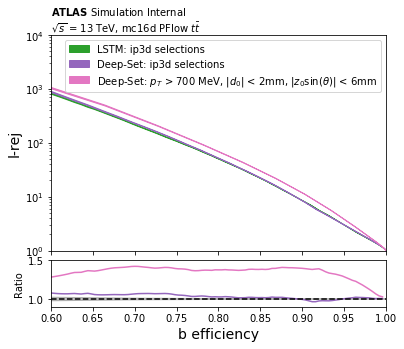

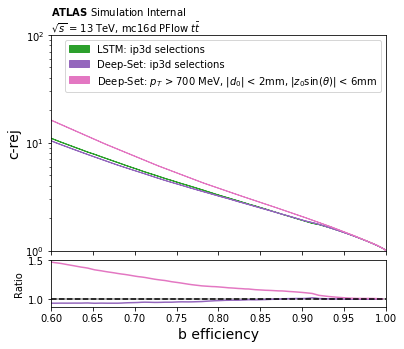

In [80]:
text="$\mathbf{ATLAS}$ Simulation Internal\n"
text+=r"$\sqrt{s}$ = 13 TeV, mc16d PFlow $t\bar{t}$"

labels = ['LSTM: ip3d selections',
          'Deep-Set: ip3d selections',
          r'Deep-Set: $p_T$ > 700 MeV, $|d_0|$ < 2mm, $|z_0 \sin(\theta)|$ < 6mm']

plotROCRatio(beffs, leffs, labels, rrange=(0.9,1.5), ymax=1e4, legLoc='upper right', text=text,
             ylabel='l-rej',binomialErrors=True,nTest=nTest,colors=['C2','C4','C6'],
             figDir=figDir,subDir=subDir+'/deep-sets',tag='lrej_loosenCuts')
    
plotROCRatio(beffs, ceffs, labels, rrange=(0.9,1.5),ymax=100, legLoc='upper right', text=text,
             ylabel='c-rej',binomialErrors=True,nTest=nTest,colors=['C2','C4','C6'],
             figDir=figDir,subDir=subDir+'/deep-sets',tag='crej_loosenCuts')

Maybe for CTIDE it's superfluous to put Deep-Sets in the legend when the message is "looser is better"?

../../plottingFcts.py:573: RuntimeWarning: invalid value encountered in sqrt
  eff_err = lambda x, N: np.sqrt( x*(1-x) / N)
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:147: RuntimeWarning: divide by zero encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:147: RuntimeWarning: invalid value encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:165: RuntimeWarning: invalid value encountered in true_divide
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:117: RuntimeWarning: invalid value encountered in multiply
  d = ((2*h0 + h1)*m0 - h0*m1) / (h0 + h1)


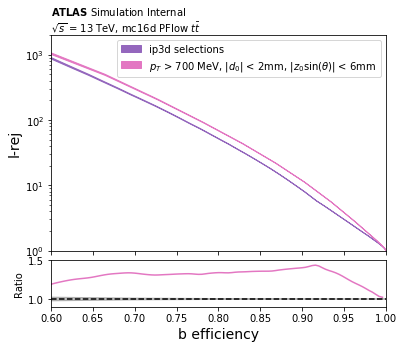

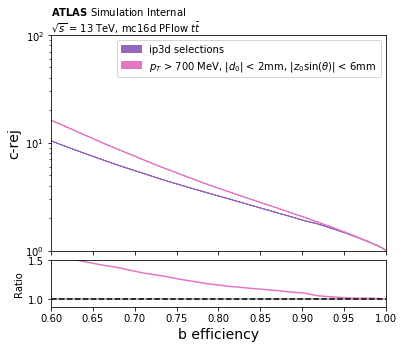

In [81]:
labels = ['ip3d selections',
          r'$p_T$ > 700 MeV, $|d_0|$ < 2mm, $|z_0 \sin(\theta)|$ < 6mm']

plotROCRatio(beffs[1:], leffs[1:], labels, rrange=(0.9,1.5), ymax=2e3, legLoc='upper right', text=text,
             ylabel='l-rej',binomialErrors=True,nTest=nTest,colors=['C4','C6'],
             figDir=figDir,subDir=subDir+'/deep-sets',tag='lrej_loosenCuts_noLSTM')
    
plotROCRatio(beffs[1:], ceffs[1:], labels, rrange=(0.9,1.5),ymax=100, legLoc='upper right', text=text,
             ylabel='c-rej',binomialErrors=True,nTest=nTest,colors=['C4','C6'],
             figDir=figDir,subDir=subDir+'/deep-sets',tag='crej_loosenCuts_noLSTM')

**Caveat:** I totally ignored the pixel and SCT hits for this study, but I think the tracking "Loose" requirement is the same as my quality cuts, with the only additional cut that they require no more than 1 shared module along the track.

So, I think I should try adding the track classification to the b-tag optimization framework to see if I could apply this cut more easily offline, without being dishonest about the # of Si hits cuts.